In [1]:
import abacusnbody
import abacusnbody.analysis
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.fft import rfftn, irfftn, fftfreq, rfftfreq
from scipy.optimize import minimize
from abacusnbody.analysis.power_spectrum import calc_pk_from_deltak
import scipy as sp
import gc

In [2]:
# Parameters

In [28]:
nmesh = 1024
npart = 2100
Lbox = 64.6917  # cMpc/h
k_bin_edges = np.linspace(0.08, 20, 101)
mu_bin_edges = np.array([0, 1.])
z_IC = 20. 
snap_int = 23 #40 #23, 34, 40, 48, 54, 61, 70, 76
snap_dict = {0: [z_IC, -1], 40: [8.3, 168], 48: [7.5, 209], 54: [7.0, 240], 75: [5.75, 342], 70: [6.0, 318], 61: [6.5, 276], 34: [9.0, 139], 23: [10.82, 83] }
scratch_dir = "/pscratch/sd/b/boryanah/Thesan/derived/"
thesan_dir = "/pscratch/sd/b/boryanah/Thesan/"

In [29]:
# Loading fields

In [30]:
delta_21_advected = np.load(thesan_dir+f"density_HI_{snap_dict[snap_int][1]:03d}.npy")
delta_21_advected = delta_21_advected / np.mean(delta_21_advected, dtype=np.float64) - 1.

ones_dm_advected = np.load(scratch_dir+f'ones_dm_advected_{snap_int:d}.npy')
delta_dm_advected = np.load(scratch_dir+f'delta_dm_advected_{snap_int:d}.npy')
delta_dm_squared_advected = np.load(scratch_dir+f'delta_dm_squared_advected_{snap_int:d}.npy')
s2_dm_advected = np.load(scratch_dir+f's2_dm_advected_{snap_int:d}.npy')
nabla2_dm_advected = np.load(scratch_dir+f'nabla2_dm_advected_{snap_int:d}.npy')

ones_dm_advected = ones_dm_advected/np.mean(ones_dm_advected, dtype=np.float64) - 1.
delta_dm_advected = delta_dm_advected/(npart/nmesh)**3
delta_dm_squared_advected = delta_dm_squared_advected/(npart/nmesh)**3
s2_dm_advected = s2_dm_advected/(npart/nmesh)**3
nabla2_dm_advected = nabla2_dm_advected/(npart/nmesh)**3

In [31]:
delta_21_obs_fft = rfftn(delta_21_advected, workers=-1) / np.complex64(delta_21_advected.size)

ones_dm_advected_fft = rfftn(ones_dm_advected, workers=-1) / np.complex64(ones_dm_advected.size)
delta_dm_advected_fft = rfftn(delta_dm_advected, workers=-1) / np.complex64(delta_dm_advected.size)
delta_dm_squared_advected_fft = rfftn(delta_dm_squared_advected, workers=-1) / np.complex64(delta_dm_squared_advected.size)
s2_dm_advected_fft = rfftn(s2_dm_advected, workers=-1) / np.complex64(s2_dm_advected.size)
nabla2_dm_advected_fft = rfftn(nabla2_dm_advected, workers=-1) / np.complex64(nabla2_dm_advected.size)

del delta_21_advected, ones_dm_advected, delta_dm_advected, delta_dm_squared_advected, s2_dm_advected, nabla2_dm_advected
gc.collect()

27280

In [32]:
result = calc_pk_from_deltak(delta_21_obs_fft, Lbox, k_bin_edges, mu_bin_edges)

pk = result['power']
Nmode = result['N_mode']
binned_poles = result['binned_poles']
N_mode_poles = result['N_mode_poles']
k_avg = result['k_avg']

#np.savez(f"data/power_21_obs_fft_snap{snap_int:d}.npz", pk=pk, k_bin_edges=k_bin_edges, Nmode=Nmode, k_avg=k_avg)
pk_21 = pk

In [33]:
power_dict = {}
fields = ["ones_dm_advected", "delta_dm_advected", "delta_dm_squared_advected", "s2_dm_advected", "nabla2_dm_advected"]
for i, field_i in enumerate(fields):
    result = calc_pk_from_deltak(delta_21_obs_fft, Lbox, k_bin_edges, mu_bin_edges, field2_fft=locals()[f"{field_i}_fft"])

    pk = result['power']
    Nmode = result['N_mode']
    binned_poles = result['binned_poles']
    N_mode_poles = result['N_mode_poles']
    k_avg = result['k_avg']    
    power_dict[f"delta_21_obs_{field_i}"] = pk
    
    for j, field_j in enumerate(fields):
        if i < j: continue
        result = calc_pk_from_deltak(locals()[f"{field_i}_fft"], Lbox, k_bin_edges, mu_bin_edges, field2_fft=locals()[f"{field_j}_fft"])

        pk = result['power']
        Nmode = result['N_mode']
        binned_poles = result['binned_poles']
        N_mode_poles = result['N_mode_poles']
        k_avg = result['k_avg']
        power_dict[f"{field_i}_{field_j}"] = power_dict[f"{field_j}_{field_i}"] = pk
        
#np.savez(f"data/power_dict_snap{snap_int:d}.npz", power_dict=power_dict, k_bin_edges=k_bin_edges, mu_bin_edges=mu_bin_edges, Nmode=Nmode, k_avg=k_avg)

In [34]:
def get_power_model(one_bias, kmin=0., kmax=np.inf):
    power_model = np.zeros(len(k_avg[(k_avg < kmax) & (k_avg > kmin)]))
    for i, field_i in enumerate(fields):
        for j, field_j in enumerate(fields):
            power_model += one_bias[i] * one_bias[j] * power_dict[f"{field_i}_{field_j}"][(k_avg < kmax) & (k_avg > kmin)]
    return power_model

def get_cross_power_model(one_bias, kmin=0., kmax=np.inf):
    power_model = np.zeros(len(k_avg[(k_avg < kmax) & (k_avg > kmin)]))
    for i, field_i in enumerate(fields):
        power_model += one_bias[i] * power_dict[f"delta_21_obs_{field_i}"][(k_avg < kmax) & (k_avg > kmin)]
    return power_model

In [35]:
# Field-level fit

In [36]:
kx, ky, kz = fftfreq(nmesh, d=Lbox/nmesh)*2.*np.pi, fftfreq(nmesh, d=Lbox/nmesh)*2.*np.pi, rfftfreq(nmesh, d=Lbox/nmesh)*2.*np.pi
kx, ky, kz = np.meshgrid(kx, ky, kz, indexing='ij')
k2 = kx**2 + ky**2 + kz**2
del kx, ky, kz; gc.collect()

69

In [37]:
def mini_fun(bias):
    b1, b2, bs, bn = np.real(bias)
    delta_model_fft_cut = ones_dm_advected_fft_cut + b1*delta_dm_advected_fft_cut + b2*delta_dm_squared_advected_fft_cut + bs*s2_dm_advected_fft_cut + bn*nabla2_dm_advected_fft_cut
    diff = delta_21_obs_fft_cut - delta_model_fft_cut 
    sum_diff2 = np.sum(diff*np.conj(diff))
    return sum_diff2

In [47]:
kmax = 0.2 #0.5 #1. #0.5
kmin = 0.0 # ask Martin about HERA error and k-range, field-level fits

delta_21_obs_fft_cut = delta_21_obs_fft[(k2 < kmax**2) & (k2 > kmin**2)]
ones_dm_advected_fft_cut = ones_dm_advected_fft[(k2 < kmax**2) & (k2 > kmin**2)]
delta_dm_advected_fft_cut = delta_dm_advected_fft[(k2 < kmax**2) & (k2 > kmin**2)]
delta_dm_squared_advected_fft_cut = delta_dm_squared_advected_fft[(k2 < kmax**2) & (k2 > kmin**2)]
nabla2_dm_advected_fft_cut = nabla2_dm_advected_fft[(k2 < kmax**2) & (k2 > kmin**2)]
s2_dm_advected_fft_cut = s2_dm_advected_fft[(k2 < kmax**2) & (k2 > kmin**2)]
#k2_cut = k2[(k2 < kmax**2) & (k2 > kmin**2)]
print(np.sum((k2 < kmax**2) & (k2 > kmin**2)))

22


In [48]:
x0 = [1., 1., 1., 1.] # initial guess for the bias parameters
res = minimize(mini_fun, x0, method='Powell')
b1, b2, bs, bn = np.real(res['x'])
print(b1, b2, bs, bn)
one_bias = np.array([1., b1, b2, bs, bn])

# construct model (only need if looking at other statistics)
#delta_model_fft = ones_dm_advected_fft + b1*delta_dm_advected_fft + b2*delta_dm_squared_advected_fft + bs*s2_dm_advected_fft + bn*nabla2_dm_advected_fft

-0.5556419803671516 -1.0932421554953906 3.5216460774950398 0.001014810371446226


/global/homes/b/boryanah/anaconda3/envs/desc/lib/python3.7/site-packages/scipy/optimize/optimize.py:3075: ComplexWarning: Casting complex values to real discards the imaginary part
  direc[-1] = direc1


In [49]:
# kmax = 0.2: -0.9698155163972996 -1.6037365298215223 3.949551332878755 0.004222847968534695
# kmax = 0.5: -0.13277050388573838 -0.6881333336236318 0.5274073229366312 0.0018998010945043468

In [50]:
pk_mod = get_power_model(one_bias, kmin=0., kmax=np.inf)
pk_21_mod = get_cross_power_model(one_bias, kmin=0., kmax=np.inf)
r_pk = pk_21_mod/(np.sqrt(pk_21*pk_mod))

In [51]:
# Alternatuve fit from "Priors on red galaxy stochasticity from hybrid effective field theory"

In [40]:
operators = ["delta_dm_advected", "delta_dm_squared_advected", "s2_dm_advected", "nabla2_dm_advected"]
A_dict = {}
M_dict = {}
for i, operator_i in enumerate(operators):
    A_dict[operator_i] = np.sum(locals()[f"{operator_i}_fft_cut"]*np.conj(delta_21_obs_fft_cut - ones_dm_advected_fft_cut))
    for j, operator_j in enumerate(operators):
        if i < j: continue
        M_dict[f"{operator_i}_{operator_j}"] = np.sum(locals()[f"{operator_i}_fft_cut"]*np.conj(locals()[f"{operator_j}_fft_cut"]))
        M_dict[f"{operator_j}_{operator_i}"] = np.conj(M_dict[f"{operator_i}_{operator_j}"])

In [41]:
A_vect = np.zeros(len(operators))
M_matr = np.zeros((len(operators), len(operators)))
for i in range(len(operators)):
    A_vect[i] = A_dict[operators[i]]
    for j in range(len(operators)):
        M_matr[i, j] = M_dict[f"{operators[i]}_{operators[j]}"]
one_bias_alt = np.hstack((1., np.dot(np.linalg.inv(M_matr), A_vect)))
print(one_bias_alt)

[ 1.00000000e+00  1.90382401e-01 -4.44120710e-01  5.03665771e-01
  9.58046689e-05]


/global/homes/b/boryanah/anaconda3/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
/global/homes/b/boryanah/anaconda3/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [25]:
pk_mod_alt = get_power_model(one_bias_alt, kmin=0., kmax=np.inf)
pk_21_mod_alt = get_cross_power_model(one_bias_alt, kmin=0., kmax=np.inf)
r_pk_alt = pk_21_mod_alt/(np.sqrt(pk_21*pk_mod_alt))

In [57]:
# TESTING
pk_mod = pk_mod_alt
r_pk = r_pk_alt

In [16]:
# Power-spectrum fit

In [52]:
def mini_fun_pk(bias, kmin=0., kmax=np.inf):
    one_bias = np.hstack(([1.], bias))
    pk_mod_cut = get_power_model(one_bias, kmin, kmax)
    pk_21_cut = pk_21[(k_avg < kmax) & (k_avg > kmin)]
    sum_diff2 = np.sum((pk_21_cut-pk_mod_cut)**2)
    return sum_diff2


In [56]:
x0 = [1., 1., 1., 1.] # initial guess for the bias parameters
kmax = 1. #10.
kmin = 0.
res = minimize(mini_fun_pk, x0, args=(kmin, kmax), method='Powell')
b1_fit, b2_fit, bs_fit, bn_fit = res['x']
print(b1_fit, b2_fit, bs_fit, bn_fit)
one_bias_fit = np.array([1., b1_fit, b2_fit, bs_fit, bn_fit])

-0.3256967412872884 -0.25895555880706905 -0.6259392229674187 0.011680447128028302


In [54]:
# TESTING
one_bias_fit = np.array([1., b1, b2, bs, bn])

In [55]:
pk_mod_fit = get_power_model(one_bias_fit, kmin=0., kmax=np.inf)
pk_21_mod_fit = get_cross_power_model(one_bias_fit, kmin=0., kmax=np.inf)
r_pk_fit = pk_21_mod_fit/(np.sqrt(pk_21*pk_mod_fit))

In [20]:
# Testing at power-spectrum level

Text(0, 0.5, 'b(k)')

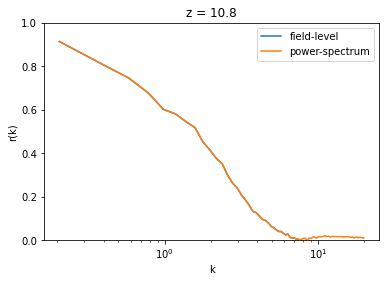

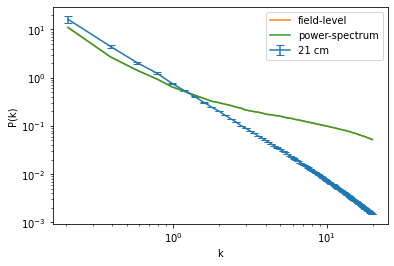

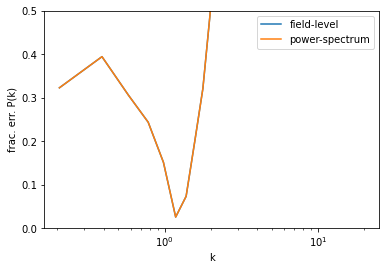

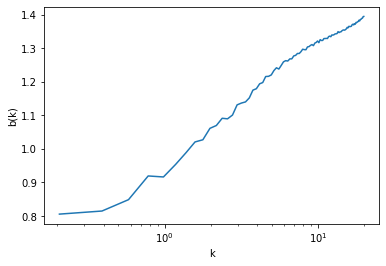

In [57]:
plt.figure(1)
plt.title(f"z = {snap_dict[snap_int][0]:.1f}")
plt.plot(k_avg, r_pk, label="field-level")
plt.plot(k_avg, np.abs(r_pk_fit), label="power-spectrum")
plt.legend()
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('r(k)')
plt.ylim([0, 1.0]) 

plt.figure(2)
plt.errorbar(k_avg, pk_21, yerr=np.sqrt(2./Nmode)*pk_21, capsize=4, label="21 cm")
plt.plot(k_avg, pk_mod, label="field-level")
plt.plot(k_avg, pk_mod_fit, label="power-spectrum")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')

plt.figure(3)
plt.plot(k_avg, np.abs((pk_mod-pk_21)/pk_21), label="field-level")
plt.plot(k_avg, np.abs((pk_mod_fit-pk_21)/pk_21), label="power-spectrum")
plt.legend()
plt.xscale('log')
plt.xlabel('k')
plt.ylim([0, 0.5]) 
plt.ylabel('frac. err. P(k)')

plt.figure(4)
plt.plot(k_avg, np.sqrt(pk_21/power_dict['ones_dm_advected_ones_dm_advected']))
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('b(k)')

In [155]:
# TESTING

In [160]:
# Class P_lin(k)

In [156]:
from classy import Class
import numpy as np

#Start by specifying the cosmology
Omega_b = 0.05
Omega_m = 0.3
Omega_cdm = Omega_m - Omega_b
h = 0.7 #H0/100
A_s = 2.1e-9
n_s = 0.96

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 20 #UNITS: 1/Mpc

params = {
             'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology andcompute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
z = snap_dict[snap_int][0]

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [49]:
pk_ones_dm = power_dict['ones_dm_advected_ones_dm_advected']
pk_delta_dm = power_dict['delta_dm_advected_delta_dm_advected']
pk_delta_dm_squared = power_dict['delta_dm_squared_advected_delta_dm_squared_advected']
pk_s2_dm = power_dict['s2_dm_advected_s2_dm_advected']
pk_nabla2_dm = power_dict['nabla2_dm_advected_nabla2_dm_advected']

plt.figure(1)
plt.plot(k_avg, np.sqrt(pk_delta_21/np.interp(k_avg, k, Plin)))
plt.xscale('log')

plt.figure(2)
plt.plot(k_avg, pk_21, color='k', label="21cm") # *k_avg**3/2*np.pi**2
plt.plot(k_avg, np.interp(k_avg, k, Plin), color='k', ls='--', label="linear")
#plt.plot(k_avg, np.interp(k_avg, k, Pnonlin), color='k', ls=':', label="non-linear")
plt.plot(k_avg, pk_ones_dm, label="ones")
plt.plot(k_avg, pk_delta_dm, label="delta")
plt.plot(k_avg, pk_delta_dm_squared, label="delta2")
plt.plot(k_avg, pk_s2_dm, label="s2")
plt.plot(k_avg, pk_nabla2_dm, label="nabla2")
plt.legend()
plt.xscale('log')
plt.yscale('log')

NameError: name 'pk_delta_21' is not defined

<Figure size 432x288 with 0 Axes>

In [158]:
# Growth factor

In [3]:
def delta_growth_factor(z,omega_m0):
    a = 1/(z+1) #Scale factor
    w = -1 #EoS for the Dark Energy. We assume w=-1 for standard DE.
    omega_m = (omega_m0*a**(-3))/(omega_m0*a**(-3)+(1-omega_m0))

    delta =  a*sp.special.hyp2f1( (w-1)/(2*w) , -1/(3*w) ,
                               1- 5/(6*w),1 - 1/omega_m )

    return delta

def growth_factor(z,omega_m0=0.27):
    num = delta_growth_factor(z, omega_m0=omega_m0)
    den = delta_growth_factor(0, omega_m0=omega_m0)
    dz = num/den
    return dz

#print(growth_factor(snap_dict[snap_int][0], omega_m0=0.3089)/growth_factor(z_IC, omega_m0=0.3089))
print(growth_factor(0., omega_m0=0.3089)/growth_factor(99., omega_m0=0.3089))

78.42699210333619


In [65]:
# Autocorreletion of model
result = calc_pk_from_deltak(delta_model_fft, Lbox, k_bin_edges, mu_bin_edges)

pk = result['power']
Nmode = result['N_mode']
binned_poles = result['binned_poles']
N_mode_poles = result['N_mode_poles']
k_avg = result['k_avg']

#np.savez(f"data/power_delta_model_fft_snap{snap_int:d}.npz", pk=pk, k_bin_edges=k_bin_edges, Nmode=Nmode, k_avg=k_avg)
pk_mod = pk